# Semantic Segmentation: 2 rings

**Goal:** I now have a slot attention block that is training, but I'm curious how low the loss should get, even w/o the SA block, so i'm going to try training the backbone CNN encoder that I have to predict the segmentation that I have for two rings.

<img src="CS231n-L11-s5.png" />
 
Image illustrating semantic segmentation from Lecture 11 of Stanford's CS231n course.
 
For more complicated images, tricks like downsampling and upsampling are employed, but I'm guessing(?) that they're not needed for an image this simple?

In [16]:
import torch
import matplotlib.pyplot as plt

import os
os.sys.path.append('code')
from plotting import plot_kslots
from data import make_batch
from model import build_grid, SoftPositionalEmbed

Perfect! `torch.nn.CrossEnropyLoss` can let the targets be the class probabilities so I'm _good to go_!

**TO DO:**
1. Define the model (same as `Encoder-optimization-rings.ipynb`)
2. Define the loss
3. Train
4. Look at pictures :)

## 1. Define the model

**Note:** For the single ring semantic segmentation task, I needed to have the output go to a `Sigmoid` layer, but for the 2 ring classification, need the output to be the **logits**. 

In [2]:
device='cuda:0'

In [3]:
hidden_dim = 32

model = torch.nn.Sequential(
            torch.nn.Conv2d(1, hidden_dim, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, hidden_dim, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_dim, 3, 5, padding=2),
    ).to(device)


## Train the model

In [4]:
# def train(model, 
Ntrain = 40_000

lr=3e-4
warmup_steps=5_000
decay_rate = 0.5
decay_steps = 50_000
kwargs={'isRing': True, 'N_clusters':2}
plot_every=250

**To do:** Need to modify the `make_batch` function to also have a background mask 

In [86]:
def train(model, 
          Ntrain = 40_000,
          bs=4,
          lr=3e-4,
          warmup_steps=5_000,
          decay_rate = 0.5,
          decay_steps = 50_000,
          kwargs={'isRing': True, 'N_clusters':2},
          plot_every=250):
    
    # Learning rate schedule config
    base_learning_rate = lr

    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()

    # resolution = model.resolution
    kwargs['device'] = device

    max_n_rings = kwargs['N_clusters']
    isRing = kwargs["isRing"]
    print(f'Training semantic segmentation task on {max_n_rings}'+ ("rings" if isRing else "blobs"))

    losses = []

    
    for i in range(Ntrain):

        learning_rate = base_learning_rate * decay_rate ** (i / decay_steps)
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)

        opt.param_groups[0]['lr'] = learning_rate

        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        # Modify the mask to include the bkg as well
        bkg_mask = 1-mask.sum(axis=1,keepdim=True)
        new_mask = torch.cat([mask,bkg_mask],axis=1)

        logits = model(X)

        # Calculate the loss
        loss = torch.nn.CrossEntropyLoss(weight=torch.Tensor([1,1,0.1]).to(device))(logits,new_mask)

        loss.backward()
        opt.step()
        opt.zero_grad()

        losses.append(float(loss))

        if i % plot_every == 0:
            print('iter',i,', loss',loss.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])

            iEvt = 0

            with torch.no_grad():
                att_img = torch.nn.Softmax(dim=1)(logits)[iEvt]

            plot_kslots(losses, 
                        mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
                        att_img.detach().cpu().numpy(),
                        max_n_rings+1, color='deeppink',cmap='PuRd',showImg=True,
                        # figname=f'{figDir}/loss-slots-iter{i}-evt{iEvt}.jpg',showImg=showImg
                       )

    model.eval()
    return model,losses

In [24]:
logits.shape

torch.Size([4, 3, 32, 32])

Ah... I probably should have shuffled the images for a more fair segmentation.

In [ ]:
# for iEvt in range(100):

#     with torch.no_grad():
#         att_img = torch.nn.Softmax(dim=1)(logits)[iEvt]

#     plot_kslots(losses, 
#                 mask[iEvt].sum(axis=0).detach().cpu().numpy(), 
#                 att_img.detach().cpu().numpy(),
#                 max_n_rings+1, color='deeppink',cmap='PuRd',showImg=True,
#                 # figname=f'{figDir}/loss-slots-iter{i}-evt{iEvt}.jpg',showImg=showImg
#                )

(0.0, 0.1)

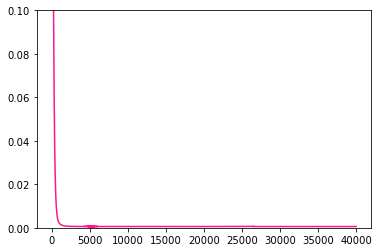

In [13]:
plt.plot(losses,color='deeppink')
plt.ylim(0,.1)

**Next proposal:** I was wondering if maybe it's a lot harder to learn about multiple rings w/o more mixing of information, so I had a couple of ideas to diagnose this:

1. Try adding the positional embedding here
2. Use a "bottleneck" representation of going to lower dimensions to encode the latent space and then going back out
    - Issue: I don't think they used this for the SA googl repo
3. Maybe do something like U-nets with skip connections?
    - Also was a key trick to getting diffusion models to work
4. Read the Fast(er)-RCNN papers, as these are often cited in the object condensation papers.

In [ ]:
    hidden_dim = 32

    model = torch.nn.Sequential(
                torch.nn.Conv2d(1, hidden_dim, 5, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv2d(hidden_dim, hidden_dim, 5, padding=2),
                torch.nn.ReLU(),
                torch.nn.Conv2d(hidden_dim, 3, 5, padding=2),
        ).to(device)


In [67]:
class encoder(torch.nn.Module):
    def __init__(self, resolution=(32,32), hidden_dim=32,device=device):
        '''
        The CNN encoder from the SlotAttentionPosEmbed class that I'm testing
        '''
        super().__init__()

        self.resolution = resolution
        self.hidden_dim = hidden_dim
        
        filter_size=5
        self.CNN_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
        
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution, device)
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,3)
        )
    
    def forward(self,data):
        
        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        
        encoded_data = self.mlp(encoded_data)
        
        logits = encoded_data.reshape(-1,32,32,3).permute(0,3,1,2)
        
        return logits
        

In [64]:
# Once burned, twice cautious! 
# Sanity check the reshaping is correct

X0 = torch.randn(4,3,32,32)

X = torch.permute(X0,(0,2,3,1)) # channel dim @ the end
X = torch.flatten(X,1,2) # flatten the pixel dims

# Nice to know -- either of these two ways works!
# X = X.permute(0,2,1).reshape(-1,3,32,32)
X = X.reshape(-1,32,32,3).permute(0,3,1,2)


print(torch.max(torch.abs(X0-X)))

tensor(0.)


In [84]:
cnn_pos = encoder().to(device)

X, Y, mask = make_batch(N_events=bs, **kwargs)
out = cnn_pos(X)

out.shape

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


torch.Size([4, 3, 32, 32])

Training semantic segmentation task on 2rings
iter 0 , loss 0.17701611 , lr 0.0


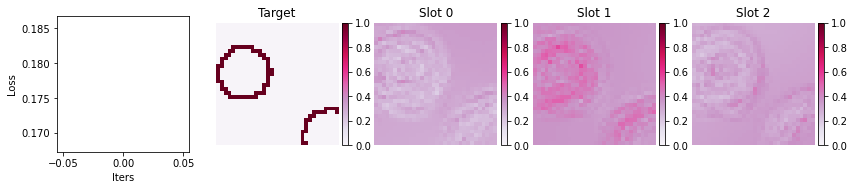

iter 250 , loss 0.1408368 , lr 1.4948103942418015e-05


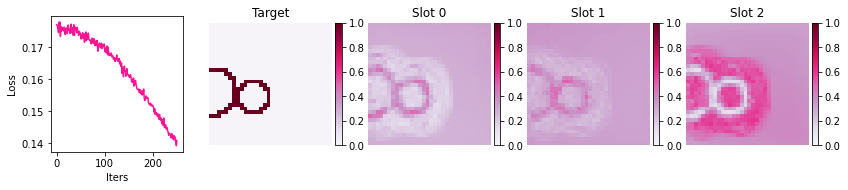

iter 500 , loss 0.08652939 , lr 2.9792774863111075e-05


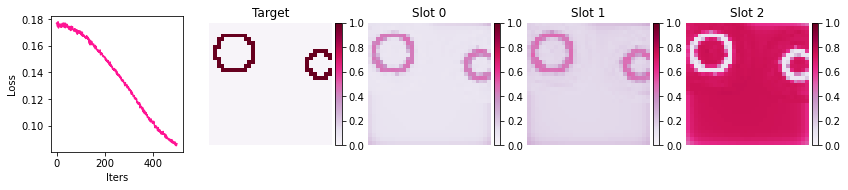

iter 750 , loss 0.06313184 , lr 4.4534549538684304e-05


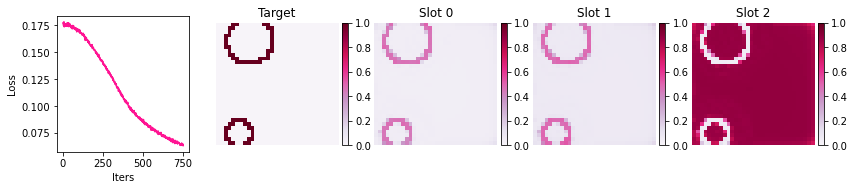

iter 1000 , loss 0.05452902 , lr 5.917396226960155e-05


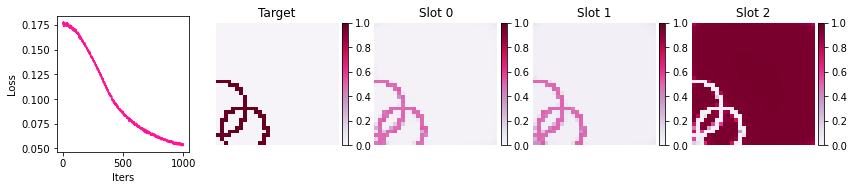

iter 1250 , loss 0.04955835 , lr 7.371154489089383e-05


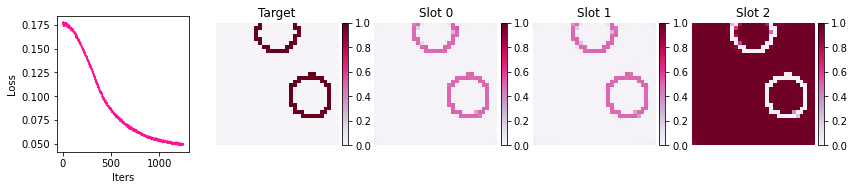

iter 1500 , loss 0.047203895 , lr 8.81478267828234e-05


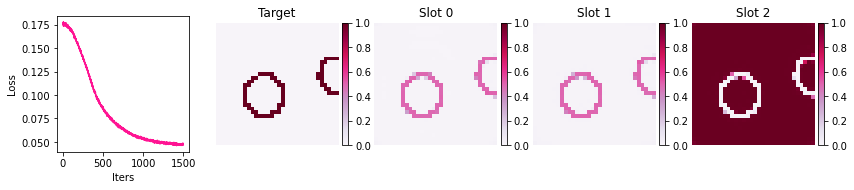

iter 1750 , loss 0.04642012 , lr 0.00010248333488150358


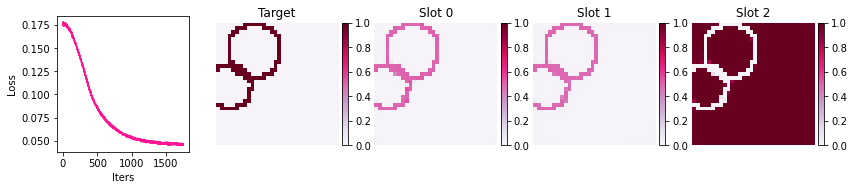

iter 2000 , loss 0.046931 , lr 0.00011671859368947427


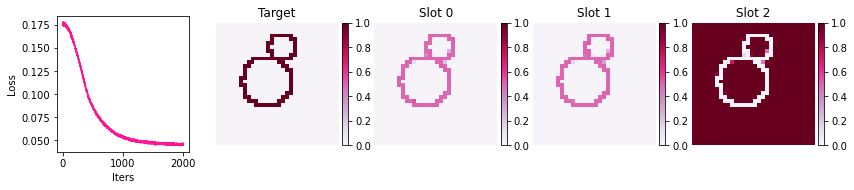

iter 2250 , loss 0.046634458 , lr 0.00013085412528623374


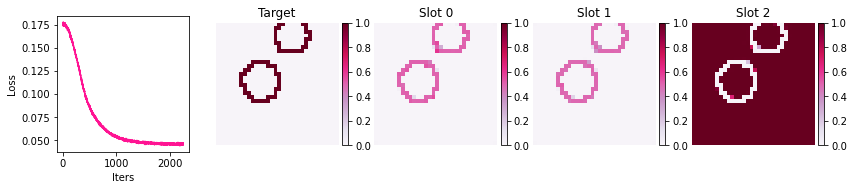

iter 2500 , loss 0.045561217 , lr 0.00014489044933872682


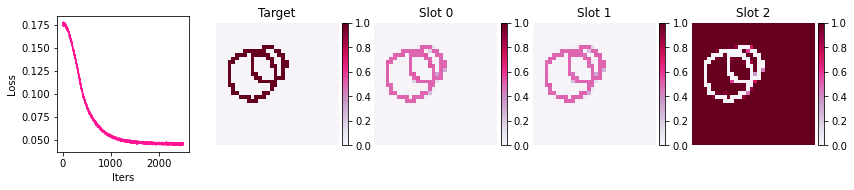

iter 2750 , loss 0.045112833 , lr 0.00015882808311178898


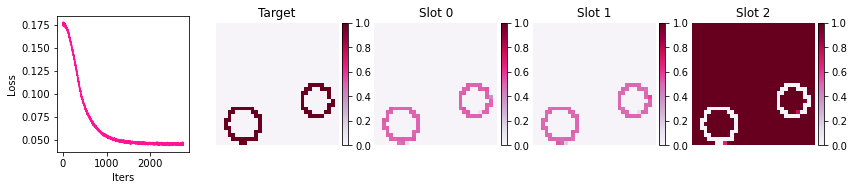

iter 3000 , loss 0.045249633 , lr 0.00017266754147854757


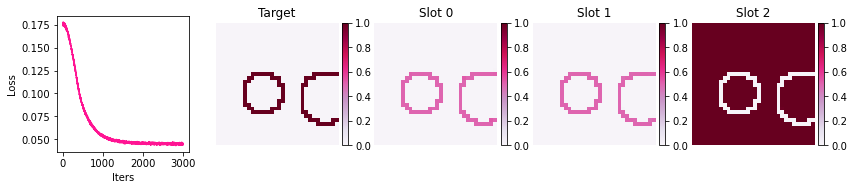

iter 3250 , loss 0.04499346 , lr 0.0001864093369307797


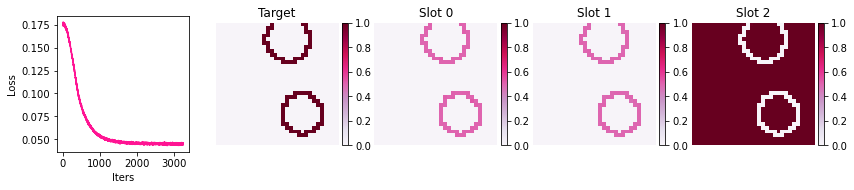

iter 3500 , loss 0.046530787 , lr 0.0002000539795892268


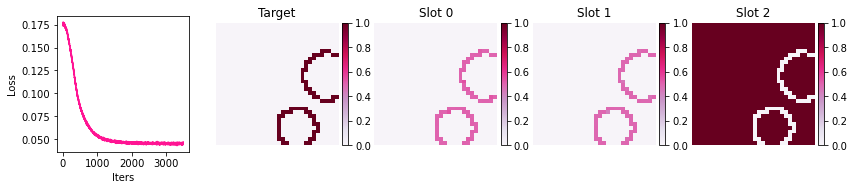

iter 3750 , loss 0.04469018 , lr 0.0002136019772138668


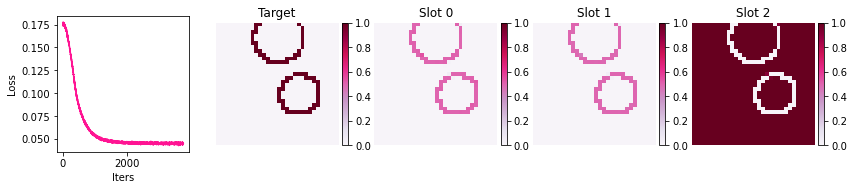

iter 4000 , loss 0.04399247 , lr 0.00022705383521414303


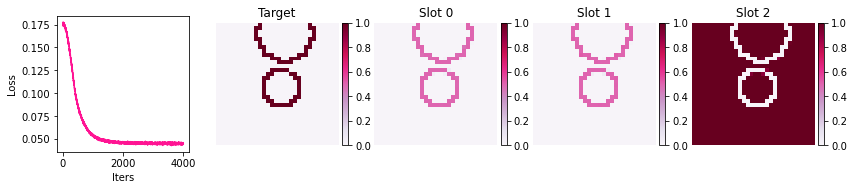

iter 4250 , loss 0.044499233 , lr 0.00024041005665915104


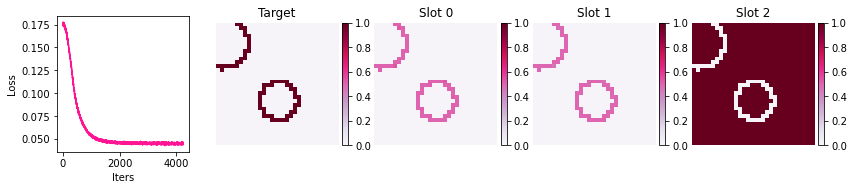

iter 4500 , loss 0.04409325 , lr 0.0002536711422877832


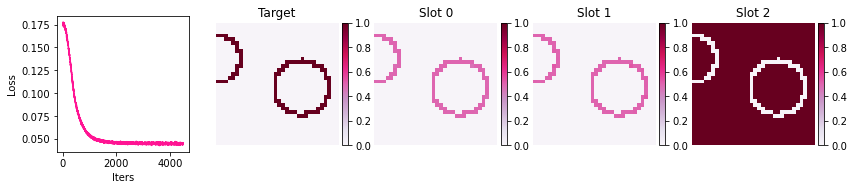

iter 4750 , loss 0.0451483 , lr 0.00026683759051883025


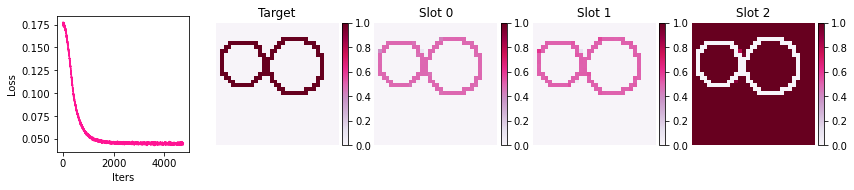

iter 5000 , loss 0.043705575 , lr 0.0002799098974610422


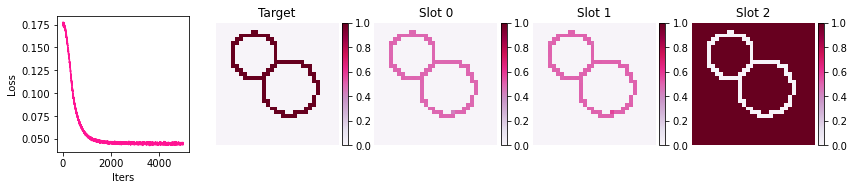

iter 5250 , loss 0.044304952 , lr 0.0002789414827839485


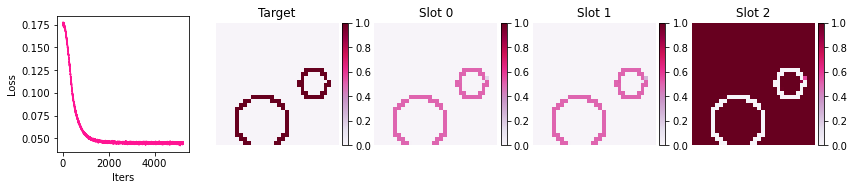

iter 5500 , loss 0.04466673 , lr 0.00027797641856711124


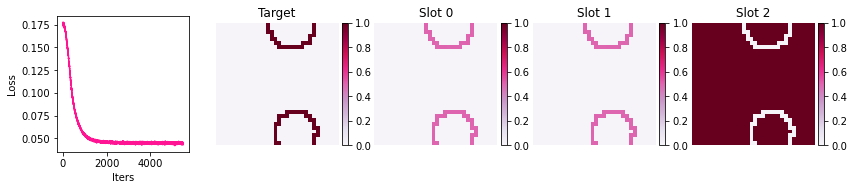

iter 5750 , loss 0.044373803 , lr 0.0002770146932188184


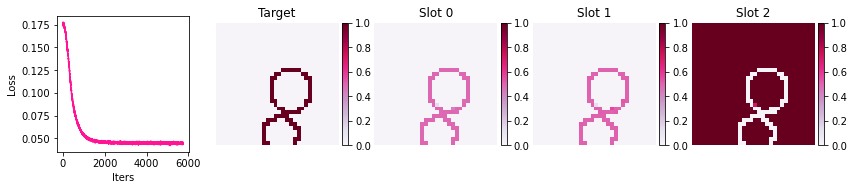

iter 6000 , loss 0.044653624 , lr 0.0002760562951874625


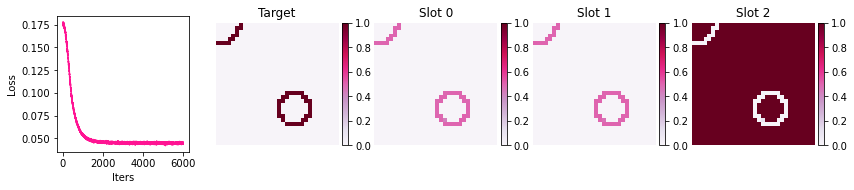

iter 6250 , loss 0.043144755 , lr 0.0002751012129614013


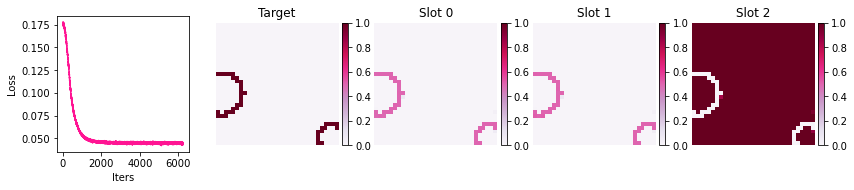

iter 6500 , loss 0.04570722 , lr 0.0002741494350688201


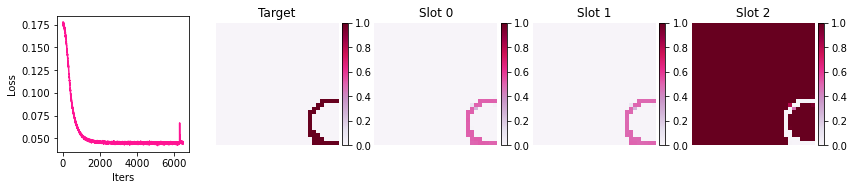

iter 6750 , loss 0.044273693 , lr 0.0002732009500775935


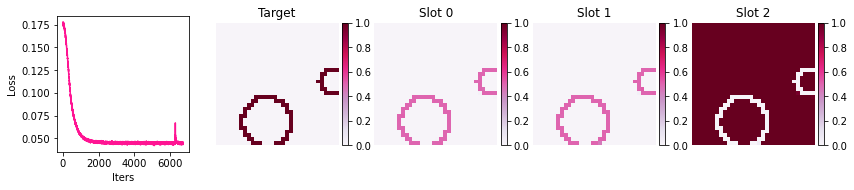

iter 7000 , loss 0.04479581 , lr 0.00027225574659514823


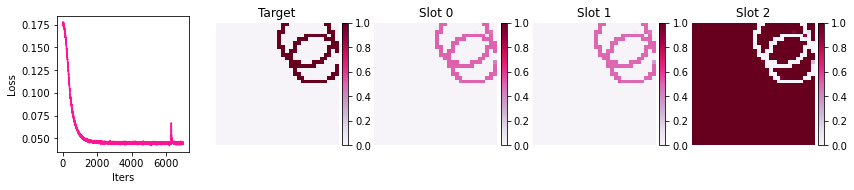

iter 7250 , loss 0.044412486 , lr 0.0002713138132683264


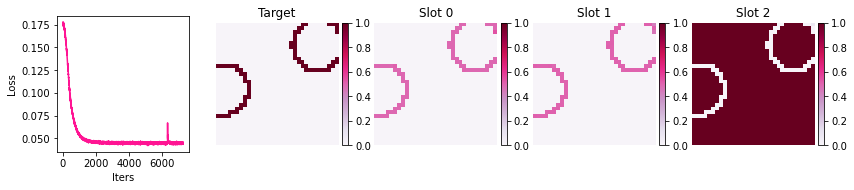

iter 7500 , loss 0.04499349 , lr 0.00027037513878324905


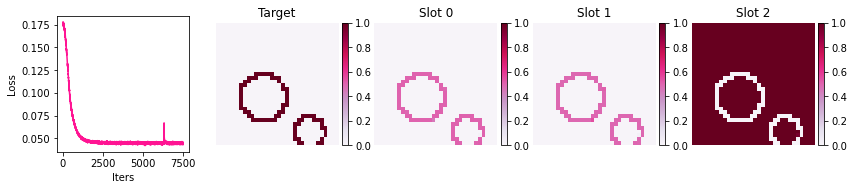

iter 7750 , loss 0.04463759 , lr 0.00026943971186518025


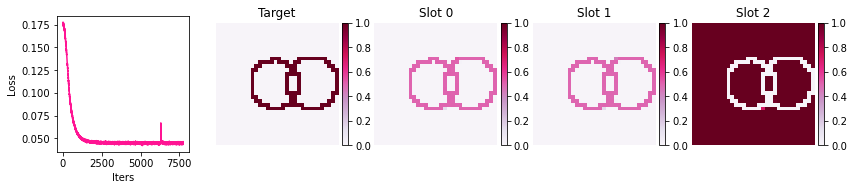

iter 8000 , loss 0.044519905 , lr 0.00026850752127839173


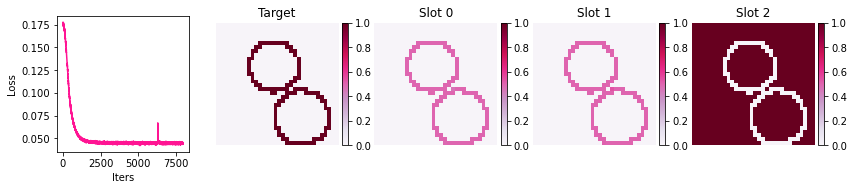

iter 8250 , loss 0.044480294 , lr 0.00026757855582602776


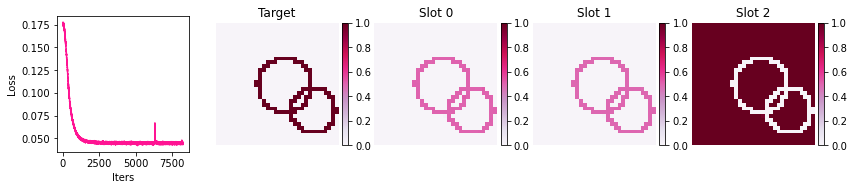

iter 8500 , loss 0.043103945 , lr 0.00026665280434997105


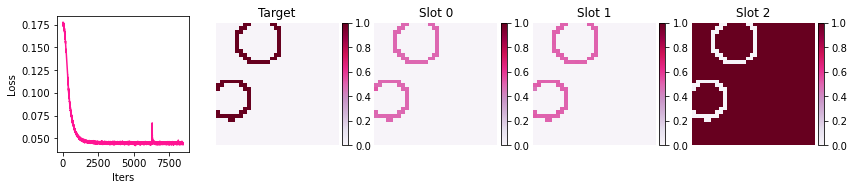

iter 8750 , loss 0.04300973 , lr 0.00026573025573070814


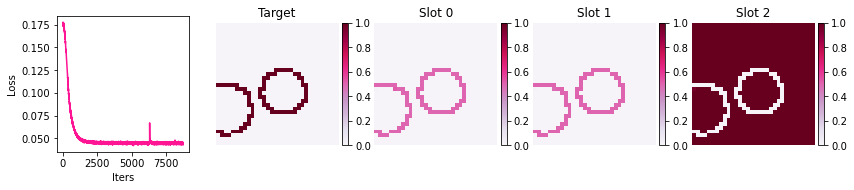

iter 9000 , loss 0.043726683 , lr 0.00026481089888719643


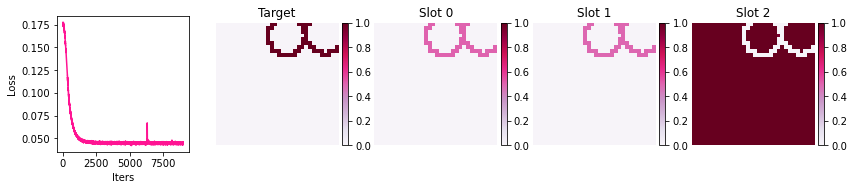

iter 9250 , loss 0.04404454 , lr 0.0002638947227767307


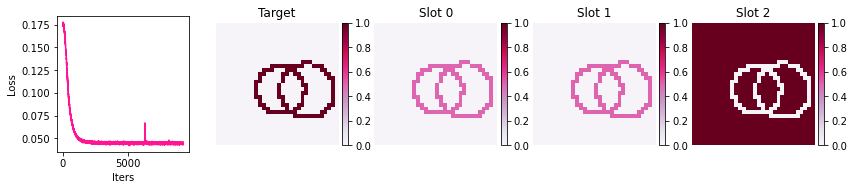

iter 9500 , loss 0.04456496 , lr 0.0002629817163948105


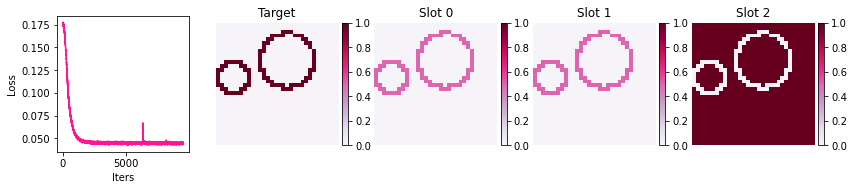

iter 9750 , loss 0.044913214 , lr 0.00026207186877500826


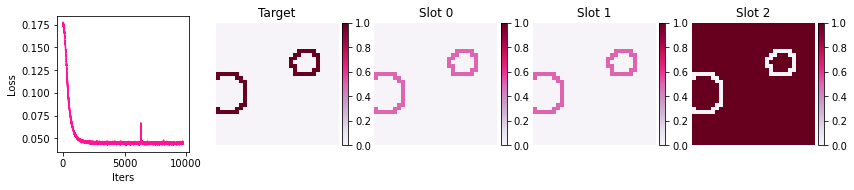

In [ ]:
cnn_pos,losses = train(cnn_pos,bs=256)